 # Data import


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("Welcome to covAI-19 study!")

#load data
covid_19_data = pd.read_csv('data\kaggle\input\covid_19_data.csv', header=0, index_col=0, parse_dates=['ObservationDate'], squeeze=True)
covid_19_line_list_data = pd.read_csv('data\kaggle\input\COVID19_line_list_data.csv', header=0, index_col=0, parse_dates=['reporting date'], squeeze=True)
covid_19_open_line_list = pd.read_csv('data\kaggle\input\COVID19_open_line_list.csv', header=0, index_col=0, parse_dates=['date_confirmation'], squeeze=True)

INFO:root:Welcome to covAI-19 study!


# Data country filter

In [2]:
covid_19_data_countryFiltered = None
covid_19_line_list_data_countryFiltered = None
covid_19_open_line_list_countryFiltered = None

def loadData(_COUNTRY_covid_19_data = 'Mainland China', _COUTNRY_covid_19_line_list_data = 'China', _COUTNRY_covid_19_open_line_list = 'China'):
    global covid_19_data_countryFiltered
    covid_19_data_countryFiltered = covid_19_data[covid_19_data['Country/Region'].eq(_COUNTRY_covid_19_data)]
    if (_COUNTRY_covid_19_data == 'Mainland China'):
        #for Mainland China we have the data grouped by cities; here cumulative data are grouped per Country (as for Italy and others Countries)
        #Ex. 
        #806,02/05/2020,,France,2020-02-01T01:52:40,6.0,0.0,0.0
        #815,02/05/2020,,Italy,2020-01-31T08:15:53,2.0,0.0,0.0
        #826,02/05/2020,Tibet,Mainland China,2020-02-01T01:52:40,1.0,0.0,0.0
        #837,02/06/2020,Hubei,Mainland China,2020-02-06T23:23:02,22112.0,618.0,817.0
        aggregate = covid_19_data_countryFiltered.groupby('ObservationDate').sum()
        aggregate = aggregate.reset_index()
        covid_19_data_countryFiltered = aggregate
    global covid_19_line_list_data_countryFiltered
    covid_19_line_list_data_countryFiltered = covid_19_line_list_data[covid_19_line_list_data['country'].eq(_COUTNRY_covid_19_line_list_data)]
    global covid_19_open_line_list_countryFiltered
    covid_19_open_line_list_countryFiltered = covid_19_open_line_list[covid_19_open_line_list['country'].eq(_COUTNRY_covid_19_open_line_list)]

In [3]:
import matplotlib.pyplot as plt
%matplotlib notebook 

def plotChart(covid_19_data_countryFiltered, countryName):
    # Create figure and plot space
    fig, ax = plt.subplots(figsize=(10, 10))

    # Add x-axis and y-axis
    confirmedLine, = ax.plot(covid_19_data_countryFiltered['ObservationDate'],
                        covid_19_data_countryFiltered['Confirmed'],
                        color='purple')
    confirmedLine.set_label('confirmed')

    deathsLine, = ax.plot(covid_19_data_countryFiltered['ObservationDate'],
                        covid_19_data_countryFiltered['Deaths'],
                        color='red')
    deathsLine.set_label('deaths')

    recoveredLine, = ax.plot(covid_19_data_countryFiltered['ObservationDate'],
                        covid_19_data_countryFiltered['Recovered'],
                        color='yellow')
    recoveredLine.set_label('recovered')

    # Set title and labels for axes
    ax.set(xlabel="Date",
           title=countryName + " Confirmed cases COVID 19")

    ax.legend()
    ax.grid(True)

    plt.setp(ax.get_xticklabels(), rotation=45)

    plt.show()


# Features extraction

In [3]:
from datetime import datetime, timedelta
import math
#this functoin extracts the features related to the targetData using the last numberOfDays data
#example:
#target date: 13/03/2020
#numberOfDays: 7
#data to take in consideration: 06-12/03/2020
#
#dataTypes:
#    targetDate --> datetime
def featuresExtraction(covid_19_open_line_list_countryFiltered, covid_19_data_countryFiltered, targetDate, numberOfDays = 7):
    logging.info("features extraction start...")
    
    oldestDate = covid_19_open_line_list_countryFiltered['date_confirmation'].iloc[0]
    oldestDate_day = oldestDate[0:2]
    oldestDate_month = oldestDate[3:5]
    oldestDate_year = oldestDate[6:10]
    d_old = datetime(int(oldestDate_year), int(oldestDate_month), int(oldestDate_day))
    daysDifference = (targetDate - d_old).days
    
    logger.debug("targetDate: " + str(targetDate) + " oldestDate (from dataset): " + str(d_old))
    logger.debug("days between dates: " + str (daysDifference))
    
    if (daysDifference >= numberOfDays):
        dateLowerBound = targetDate - timedelta(days=numberOfDays)
        dateUpperBound = targetDate - timedelta(days=1)
        logger.info("We have enough data to calucalte features...let me go ahead...")
        logger.info("The interval that will be used: [" + str(dateLowerBound) + ", " + str(dateUpperBound) + "]")
    else:
        logger.info("Not enough data to caluclate features...exiting...")
        return None
    
    features = []
    features.append("[" + str(dateLowerBound) + ", " + str(dateUpperBound) + "]")

    #dataset covid_19_data_countryFiltered
    #increment_confirmed_previous_n_days
    yesterdayData = covid_19_data_countryFiltered[covid_19_data_countryFiltered['ObservationDate'].eq(targetDate - timedelta(days=1))]['Confirmed'].values[0]      
    nDaysAgoData = covid_19_data_countryFiltered[covid_19_data_countryFiltered['ObservationDate'].eq(targetDate - timedelta(days=numberOfDays))]['Confirmed'].values[0]       
    value = yesterdayData - nDaysAgoData 
    features.append(value)
    
    #increment_deaths_previous_n_days
    yesterdayData = covid_19_data_countryFiltered[covid_19_data_countryFiltered['ObservationDate'].eq(targetDate - timedelta(days=1))]['Deaths'].values[0]      
    nDaysAgoData = covid_19_data_countryFiltered[covid_19_data_countryFiltered['ObservationDate'].eq(targetDate - timedelta(days=numberOfDays))]['Deaths'].values[0]       
    value = yesterdayData - nDaysAgoData 
    features.append(value)
    
    #increment_recovered_previous_n_days
    yesterdayData = covid_19_data_countryFiltered[covid_19_data_countryFiltered['ObservationDate'].eq(targetDate - timedelta(days=1))]['Recovered'].values[0]      
    nDaysAgoData = covid_19_data_countryFiltered[covid_19_data_countryFiltered['ObservationDate'].eq(targetDate - timedelta(days=numberOfDays))]['Recovered'].values[0]       
    value = yesterdayData - nDaysAgoData 
    features.append(value)
    
    #dataset covid_19_open_line_list_countryFiltered    
    #creating dates in format 22.01.2020 to interact with this dataset
    dates = []
    for i in range (7):
        currentDate = targetDate - timedelta(days=i+1)
        dates.append(currentDate.strftime("%d.%m.%Y"))
    logger.debug(str(dates))
    logger.debug(covid_19_open_line_list_countryFiltered.shape)
    covid_19_open_line_list_countryDateFiltered = covid_19_open_line_list_countryFiltered[covid_19_open_line_list_countryFiltered['date_confirmation'].isin(dates)]
    logger.debug(covid_19_open_line_list_countryDateFiltered.shape)
    
    #min_age_previous_n_days
    value = pd.to_numeric(covid_19_open_line_list_countryDateFiltered['age'], errors='coerce').min()
    features.append(value)

    #max_age_previous_n_days
    value = pd.to_numeric(covid_19_open_line_list_countryDateFiltered['age'], errors='coerce').max()
    features.append(value)
    
    #mean_age_previous_n_days
    value = pd.to_numeric(covid_19_open_line_list_countryDateFiltered['age'], errors='coerce').mean()
    features.append(value)
    
    #std_age_previous_n_days
    value = pd.to_numeric(covid_19_open_line_list_countryDateFiltered['age'], errors='coerce').std()
    features.append(value)
    
    #male_count_previous_n_days
    value = covid_19_open_line_list_countryDateFiltered[covid_19_open_line_list_countryDateFiltered['sex'].eq('male')].shape[0]
    features.append(value)
    
    #female_count_previous_n_days
    value = covid_19_open_line_list_countryDateFiltered[covid_19_open_line_list_countryDateFiltered['sex'].eq('female')].shape[0]
    features.append(value)
    
    #different_cities_count_previous_n_days
    value = covid_19_open_line_list_countryDateFiltered.city.unique().size
    features.append(value)
    
    #different_province_count_previous_n_days
    value = covid_19_open_line_list_countryDateFiltered.province.unique().size
    features.append(value)
    
    #gps_coordinates_distribution_previous_n_days
    logger.warning("graph analysis not implemented yet...")
    
    #mean_num_of_days_from_onset_symptoms_previous_n_days
    #mean across all cases in the intercal of the number of days from onset sympton to the confirmation
    num_of_days_from_onset_symptoms_previous_n_days = []
    for item in range(covid_19_open_line_list_countryDateFiltered.shape[0]):
        try:
            dateOnsetSymtps = covid_19_open_line_list_countryDateFiltered.iloc[item].date_onset_symptoms 
            if isinstance(dateOnsetSymtps,float) and math.isnan(dateOnsetSymtps):
                continue
            dateOnsetSymtps_day = dateOnsetSymtps[0:2]
            dateOnsetSymtps_month = dateOnsetSymtps[3:5]
            dateOnsetSymtps_year = dateOnsetSymtps[6:10]
            d_dateOnsetSymtps = datetime(int(dateOnsetSymtps_year), int(dateOnsetSymtps_month), int(dateOnsetSymtps_day))

            dateConfirmation = covid_19_open_line_list_countryDateFiltered.iloc[item].date_confirmation 
            if isinstance(dateConfirmation,float) and math.isnan(dateConfirmation):
                continue
            dateConfirmation_day = dateConfirmation[0:2]
            dateOnsetSymtps_month = dateConfirmation[3:5]
            dateConfirmation_year = dateConfirmation[6:10]
            d_dateConfirmation = datetime(int(dateConfirmation_year), int(dateOnsetSymtps_month), int(dateConfirmation_day))

            daysDifference = (d_dateConfirmation - d_dateOnsetSymtps).days
            num_of_days_from_onset_symptoms_previous_n_days.append(daysDifference)
        except:
            logger.debug("ignoring item number " + str(item) + "...")
    value = np.mean(num_of_days_from_onset_symptoms_previous_n_days)
    features.append(value)
    
    #variance_num_of_days_from_onset_symptoms_previous_n_days
    value = np.var(num_of_days_from_onset_symptoms_previous_n_days)
    features.append(value)
    
    #sd_num_of_days_from_onset_symptoms_previous_n_days
    value = np.std(num_of_days_from_onset_symptoms_previous_n_days)
    features.append(value)
    
    #number_of_reported_trips_previous_n_days
    #number_of_trips_days_previous_n_days
    number_of_reported_trips_previous_n_days = []
    number_of_trips_days_previous_n_days = []    
    for item in range(covid_19_open_line_list_countryDateFiltered.shape[0]):
        try:    
            #numberOfTrips
            number_of_reported_trips_previous_n_days.append(len(covid_19_open_line_list_countryDateFiltered.iloc[item]['travel_history_location'].split(",")))
        except:
            logger.debug("ignoring item number " + str(item) + "...")
        try:    
            #numberOfDaysOfTrips
            number_of_trips_days_previous_n_days.append(len(covid_19_open_line_list_countryDateFiltered.iloc[item]['travel_history_dates'].split(",")))
        except:
            logger.debug("ignoring item number " + str(item) + "...")
    
    value = np.sum(number_of_reported_trips_previous_n_days)
    features.append(value)
    
    value = np.sum(number_of_trips_days_previous_n_days)
    features.append(value)
    
    
    logger.debug(str(features))
    logger.info("features extraction end...")
    return features
    

    
    #targetDate_day = targetDate[0:2]
    #targetDate_month = targetDate[3:5]
    #targetDate_year = targetDate[6:10]
    #d_target = datetime.datetime(int(targetDate_year), int(targetDate_month), int(targetDate_day))

    #covid_19_open_line_list_countryFiltered[covid_19_open_line_list_countryFiltered['date_confirmation'].eq('22.01.2020')]


# Dataset generation

## x data

In [17]:
loadData('Mainland China', 'China', 'China')
#loadData('Italy', 'Italy', 'Italy')
dataset = []

for index, item in covid_19_data_countryFiltered.iterrows():
    targetDate = item['ObservationDate']
    out = featuresExtraction(covid_19_open_line_list_countryFiltered, covid_19_data_countryFiltered, targetDate)
    logger.info("new features vecotr generated: " + str(out))
    if out is not None:#the top row we cannot generate because of "not minimun historical data..."
        logger.info("append...")
        dataset.append(out)
    

INFO:root:features extraction start...
INFO:root:Not enough data to caluclate features...exiting...
INFO:root:new features vecotr generated: None
INFO:root:features extraction start...
INFO:root:Not enough data to caluclate features...exiting...
INFO:root:new features vecotr generated: None
INFO:root:features extraction start...
INFO:root:Not enough data to caluclate features...exiting...
INFO:root:new features vecotr generated: None
INFO:root:features extraction start...
INFO:root:Not enough data to caluclate features...exiting...
INFO:root:new features vecotr generated: None
INFO:root:features extraction start...
INFO:root:Not enough data to caluclate features...exiting...
INFO:root:new features vecotr generated: None
INFO:root:features extraction start...
INFO:root:Not enough data to caluclate features...exiting...
INFO:root:new features vecotr generated: None
INFO:root:features extraction start...
INFO:root:Not enough data to caluclate features...exiting...
INFO:root:new features v

INFO:root:features extraction start...
INFO:root:We have enough data to calucalte features...let me go ahead...
INFO:root:The interval that will be used: [2020-02-04 00:00:00, 2020-02-10 00:00:00]
INFO:root:features extraction end...
INFO:root:new features vecotr generated: ['[2020-02-04 00:00:00, 2020-02-10 00:00:00]', 18626.0, 521.0, 3074.0, 1.0, 88.0, 44.55789473684211, 18.038592249929906, 97, 91, 375, 31, 7.227722772277228, 15.46299382413489, 3.9323013394366013, 139, 67]
INFO:root:append...
INFO:root:features extraction start...
INFO:root:We have enough data to calucalte features...let me go ahead...
INFO:root:The interval that will be used: [2020-02-05 00:00:00, 2020-02-11 00:00:00]
INFO:root:features extraction end...
INFO:root:new features vecotr generated: ['[2020-02-05 00:00:00, 2020-02-11 00:00:00]', 16918.0, 549.0, 3520.0, 1.0, 88.0, 43.8502994011976, 18.292347712898366, 81, 84, 320, 30, 6.8125, 16.55234375, 4.06845717072209, 110, 59]
INFO:root:append...
INFO:root:features e

INFO:root:features extraction end...
INFO:root:new features vecotr generated: ['[2020-02-19 00:00:00, 2020-02-25 00:00:00]', 3114.0, 549.0, 11698.0, 24.0, 96.0, 56.8, 23.677462326487234, 2, 3, 22, 13, 6.666666666666667, 14.555555555555557, 3.815174380753199, 0.0, 0.0]
INFO:root:append...
INFO:root:features extraction start...
INFO:root:We have enough data to calucalte features...let me go ahead...
INFO:root:The interval that will be used: [2020-02-20 00:00:00, 2020-02-26 00:00:00]
INFO:root:features extraction end...
INFO:root:new features vecotr generated: ['[2020-02-20 00:00:00, 2020-02-26 00:00:00]', 3066.0, 479.0, 12051.0, 24.0, 96.0, 55.44444444444444, 24.6987404087289, 1, 3, 10, 6, 6.666666666666667, 14.555555555555557, 3.815174380753199, 0.0, 0.0]
INFO:root:append...
INFO:root:features extraction start...
INFO:root:We have enough data to calucalte features...let me go ahead...
INFO:root:The interval that will be used: [2020-02-21 00:00:00, 2020-02-27 00:00:00]
INFO:root:features

INFO:root:append...
INFO:root:features extraction start...
INFO:root:We have enough data to calucalte features...let me go ahead...
INFO:root:The interval that will be used: [2020-03-05 00:00:00, 2020-03-11 00:00:00]
INFO:root:features extraction end...
INFO:root:new features vecotr generated: ['[2020-03-05 00:00:00, 2020-03-11 00:00:00]', 499.0, 148.0, 9404.0, nan, nan, nan, nan, 0, 0, 0, 0, nan, nan, nan, 0.0, 0.0]
INFO:root:append...
INFO:root:features extraction start...
INFO:root:We have enough data to calucalte features...let me go ahead...
INFO:root:The interval that will be used: [2020-03-06 00:00:00, 2020-03-12 00:00:00]
INFO:root:features extraction end...
INFO:root:new features vecotr generated: ['[2020-03-06 00:00:00, 2020-03-12 00:00:00]', 359.0, 130.0, 9013.0, nan, nan, nan, nan, 0, 0, 0, 0, nan, nan, nan, 0.0, 0.0]
INFO:root:append...
INFO:root:features extraction start...
INFO:root:We have enough data to calucalte features...let me go ahead...
INFO:root:The interval tha

## y data

In [18]:
future_deep_day = 7 #how many days ahead you want to predict?
                    #example: with 7, you will use the range [2020-01-26 00:00:00, 2020-02-01 00:00:00] to predict the 2020-02-08 and so on...
y_dataset = []
last_index = covid_19_data_countryFiltered.shape[0]-1
newestDateCovid_19 = covid_19_data_countryFiltered.iloc[last_index]['ObservationDate']
dataset_last_index_to_use = 0
for item in dataset:
    asNpArray = np.array(item)
    if asNpArray.size == 1:
        logger.info("no data for this row: continue...")
        continue
    upperBoundDateInterval = asNpArray[0].split(',')[1].strip()[0:10]
    date_time = datetime.strptime(upperBoundDateInterval,"%Y-%m-%d")
    target_date = date_time + timedelta(days=future_deep_day)
    logger.info(str(asNpArray[0]) + " - " + str(upperBoundDateInterval) + " - " + str(target_date))
    if (target_date > newestDateCovid_19):
        logger.info('last available target data is: ' + str(target_date) + ' -1 day...update your dataset to go ahead...')
        break
    date_formatted = target_date.strftime("%Y-%m-%d")
    target = covid_19_data_countryFiltered[covid_19_data_countryFiltered['ObservationDate'].eq(date_formatted)]
    y_dataset.append(target)
    dataset_last_index_to_use += 1
dataset_train = dataset[0:dataset_last_index_to_use]    

INFO:root:[2020-01-22 00:00:00, 2020-01-28 00:00:00] - 2020-01-28 - 2020-02-04 00:00:00
INFO:root:[2020-01-23 00:00:00, 2020-01-29 00:00:00] - 2020-01-29 - 2020-02-05 00:00:00
INFO:root:[2020-01-24 00:00:00, 2020-01-30 00:00:00] - 2020-01-30 - 2020-02-06 00:00:00
INFO:root:[2020-01-25 00:00:00, 2020-01-31 00:00:00] - 2020-01-31 - 2020-02-07 00:00:00
INFO:root:[2020-01-26 00:00:00, 2020-02-01 00:00:00] - 2020-02-01 - 2020-02-08 00:00:00
INFO:root:[2020-01-27 00:00:00, 2020-02-02 00:00:00] - 2020-02-02 - 2020-02-09 00:00:00
INFO:root:[2020-01-28 00:00:00, 2020-02-03 00:00:00] - 2020-02-03 - 2020-02-10 00:00:00
INFO:root:[2020-01-29 00:00:00, 2020-02-04 00:00:00] - 2020-02-04 - 2020-02-11 00:00:00
INFO:root:[2020-01-30 00:00:00, 2020-02-05 00:00:00] - 2020-02-05 - 2020-02-12 00:00:00
INFO:root:[2020-01-31 00:00:00, 2020-02-06 00:00:00] - 2020-02-06 - 2020-02-13 00:00:00
INFO:root:[2020-02-01 00:00:00, 2020-02-07 00:00:00] - 2020-02-07 - 2020-02-14 00:00:00
INFO:root:[2020-02-02 00:00:00, 

In [19]:
dataset_np = np.array(dataset_train)[:,1:]
dataset_np = np.nan_to_num(dataset_np, copy=False).astype(float)
dataset_np = np.nan_to_num(dataset_np, copy=False).astype(float)

y_confirmed = []
y_death = []
y_recovered = []
for item in y_dataset:
    y_confirmed.append(float(item['Confirmed']))
    y_death.append(float(item['Deaths']))
    y_recovered.append(float(item['Recovered']))

X = dataset_np #removing date interval

In [136]:
import pickle
serialized = pickle.dump(X, open( "X_China.p", "wb" ), protocol=0) # protocol 0 is printable ASCII
serialized = pickle.dump(y_confirmed, open( "y_confirmed_china.p", "wb" ), protocol=0) # protocol 0 is printable ASCII
serialized = pickle.dump(y_death, open( "y_death_china.p", "wb" ), protocol=0) # protocol 0 is printable ASCII
serialized = pickle.dump(y_recovered, open( "y_recovered_china.p", "wb" ), protocol=0) # protocol 0 is printable ASCII

In [20]:
len(y_confirmed)

40

# Features selection

# Model selection

In [8]:
from sklearn import svm, linear_model
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

In [9]:
import sklearn as sk
sk.__version__
np.__version__

'1.18.1'

## SVR grid search
https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#sphx-glr-auto-examples-svm-plot-svm-regression-py

In [ ]:
svr = svm.SVR()
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 10, 100], 'gamma':['auto']}
clf = GridSearchCV(svr, parameters)
clf.fit(X, y)
#clf.fit(X, y)
#clf.score(X, y)

In [28]:
clf.best_estimator_
item_no = 30
logger.info(str(clf.best_estimator_.predict([X[item_no]])) + " - " + str(y[item_no]))


INFO:root:[82713.89950258] - 80422.0


## Ridge grid search
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge

In [21]:
from sklearn.linear_model import Ridge

#Confirmed model
y = y_confirmed
ridge = Ridge()
parameters = {'alpha':[1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
      1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06], 'max_iter': [13000], 'solver': ['svd', 'cholesky', 'lsqr']}
clf_confirmed = GridSearchCV(ridge, parameters)
clf_confirmed.fit(X, y)

#Deaths model
y = y_death
ridge = Ridge()
parameters = {'alpha':[1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
      1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06], 'max_iter': [13000], 'solver': ['svd', 'cholesky', 'lsqr']}
clf_deaths = GridSearchCV(ridge, parameters)
clf_deaths.fit(X, y)

#Recovered model
y = y_recovered
ridge = Ridge()
parameters = {'alpha':[1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
      1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06], 'max_iter': [13000], 'solver': ['svd', 'cholesky', 'lsqr']}
clf_recovered = GridSearchCV(ridge, parameters)
clf_recovered.fit(X, y)

C:\Users\SimoneRomano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\SimoneRomano\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\SimoneRomano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\SimoneRomano\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to F

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0,
                                   10.0, 100.0, 1000.0, 10000.0, 100000.0,
                                   1000000.0],
                         'max_iter': [13000],
                         'solver': ['svd', 'cholesky', 'lsqr']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [22]:
import pickle
pickle.dump(clf_confirmed, open( "clf_confirmed_SVR.p", "wb" ), protocol=0) # protocol 0 is printable ASCII
pickle.dump(clf_deaths, open( "clf_deaths_SVR.p", "wb" ), protocol=0) # protocol 0 is printable ASCII
pickle.dump(clf_recovered, open( "clf_recovered_SVR.p", "wb" ), protocol=0) # protocol 0 is printable ASCII

# Predicted chart

In [23]:
dataset_all = np.array(dataset)[:,1:]
dataset_all = np.nan_to_num(dataset_all, copy=False).astype(float)
dataset_all = np.nan_to_num(dataset_all, copy=False).astype(float)
first_target_date = dataset[0][0].split(',')[1].strip()[0:10]
first_target_date = datetime.strptime(first_target_date,"%Y-%m-%d")
first_target_date = first_target_date + timedelta(days=future_deep_day)
logger.info(str(first_target_date))

x_plot = []
y_confirmed_predicted_plot = []
y_deaths_predicted_plot = []
y_recovered_predicted_plot = []
for item in dataset_all:
    y_confirmed_predicted_plot.append(clf_confirmed.predict([item]))
    y_deaths_predicted_plot.append(clf_deaths.predict([item]))
    y_recovered_predicted_plot.append(clf_recovered.predict([item]))
    x_plot.append(first_target_date.strftime("%Y-%m-%d"))
    first_target_date = first_target_date + timedelta(days=1)
    
#date_time = datetime.strptime(upperBoundDateInterval,"%Y-%m-%d")

INFO:root:2020-02-04 00:00:00


INFO:root:Zeros to add: 6


<IPython.core.display.Javascript object>


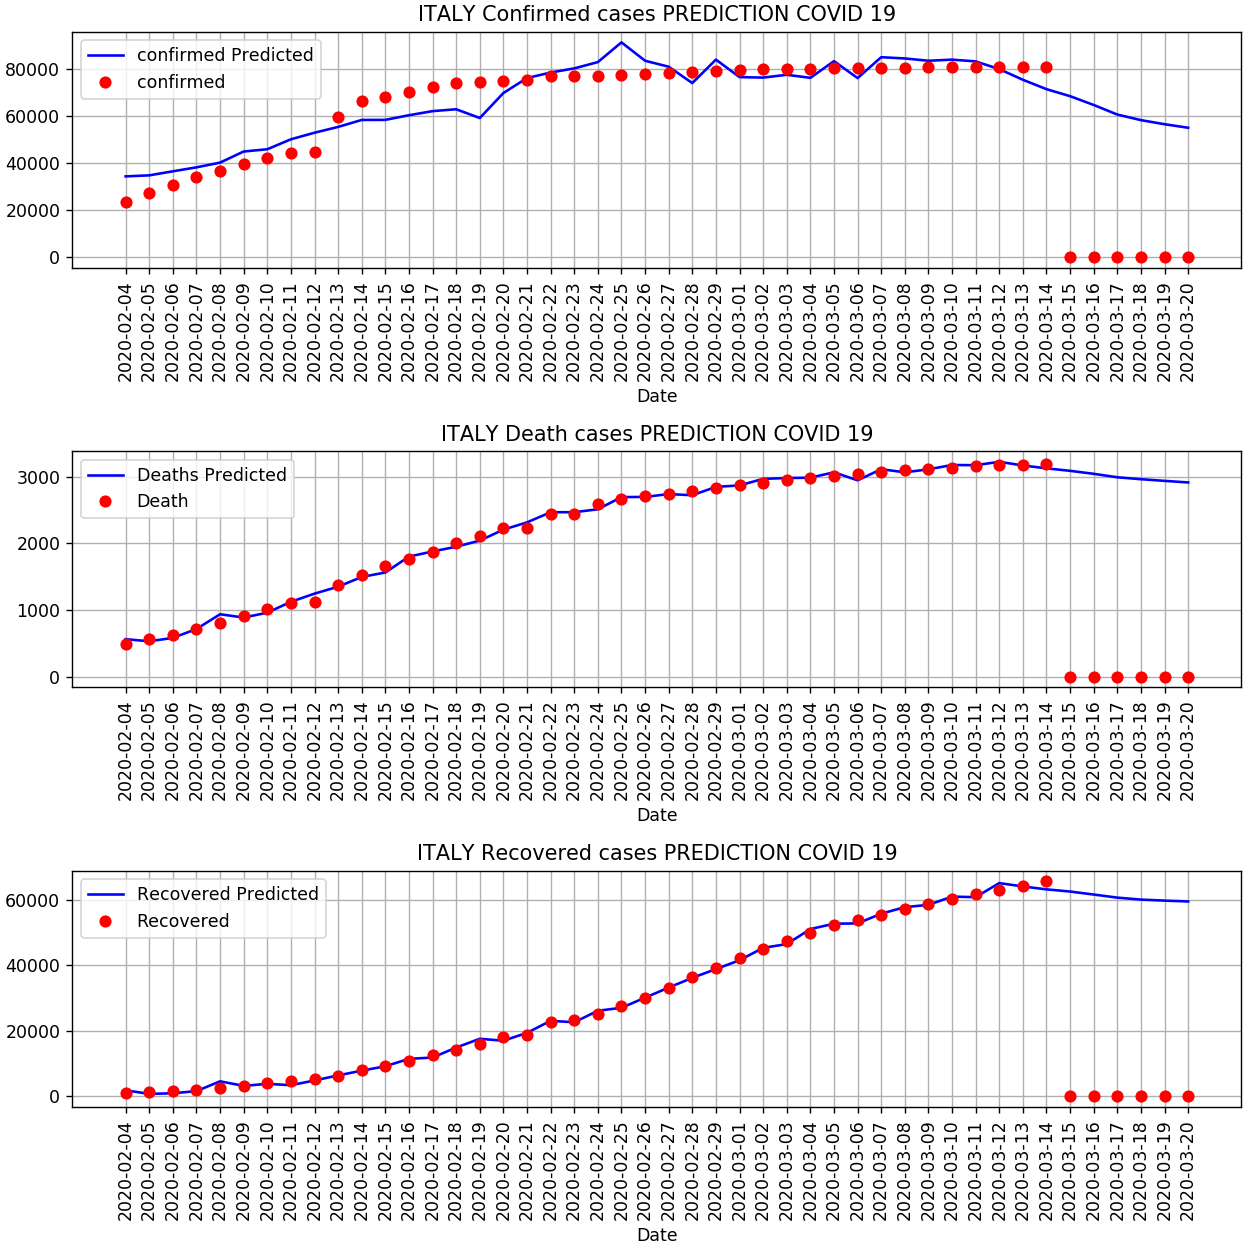

In [24]:
import matplotlib.pyplot as plt
zero_to_add = len(y_confirmed_predicted_plot) - len(y_confirmed)
logger.info("Zeros to add: " + str(zero_to_add))
for i in range(zero_to_add):
    y_confirmed.append(0)
    y_death.append(0)
    y_recovered.append(0)

_COUNTRY = "ITALY"
%matplotlib notebook 
import matplotlib.gridspec as gridspec
# Create figure and plot space


# Plot the raw time series
fig = plt.figure(constrained_layout=True, figsize=(10, 10))
gs = gridspec.GridSpec(3, 1, figure=fig)

ax = fig.add_subplot(gs[0, :])
# Add x-axis and y-axis
confirmedLine, = ax.plot(x_plot,
                    y_confirmed_predicted_plot,
                    '-b')
confirmedLine.set_label('confirmed Predicted')
# Add x-axis and y-axis
confirmedLine, = ax.plot(x_plot,
                    y_confirmed,
                    'ro')
confirmedLine.set_label('confirmed')
# Set title and labels for axes
ax.set(xlabel="Date",
       title=_COUNTRY + " Confirmed cases PREDICTION COVID 19")
ax.legend()
ax.grid(True)
plt.setp(ax.get_xticklabels(), rotation=90)


ax = fig.add_subplot(gs[1, :])
# Create figure and plot space
# Add x-axis and y-axis
confirmedLine, = ax.plot(x_plot,
                    y_deaths_predicted_plot,
                    '-b')
confirmedLine.set_label('Deaths Predicted')
# Add x-axis and y-axis
confirmedLine, = ax.plot(x_plot,
                    y_death,
                    'ro')
confirmedLine.set_label('Death')
# Set title and labels for axes
ax.set(xlabel="Date",
       title=_COUNTRY + " Death cases PREDICTION COVID 19")
ax.legend()
ax.grid(True)
plt.setp(ax.get_xticklabels(), rotation=90)


ax = fig.add_subplot(gs[2, :])
# Add x-axis and y-axis
confirmedLine, = ax.plot(x_plot,
                    y_recovered_predicted_plot,
                    '-b')
confirmedLine.set_label('Recovered Predicted')

# Add x-axis and y-axis
confirmedLine, = ax.plot(x_plot,
                    y_recovered,
                    'ro')
confirmedLine.set_label('Recovered')

# Set title and labels for axes
ax.set(xlabel="Date",
       title=_COUNTRY + " Recovered cases PREDICTION COVID 19")

ax.legend()
ax.grid(True)

plt.setp(ax.get_xticklabels(), rotation=90)

plt.show()

